# **Online Shoppers Purchasing Intention**

---

# **Stage 3 - Modeling**

# Import Library

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import sklearn

# Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import auc, roc_auc_score

# Models
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_validate

# Ignore Warning
import warnings
warnings.filterwarnings('ignore')

In [ ]:
print(f'Scikit-learn {sklearn.__version__}')

Scikit-learn 1.2.2


# Read Dataset

In [ ]:
!gdown 1-td5DtN3Lgj9QWNHeJGJqHmMMaSDOqMD # Download data train

Downloading...
From: https://drive.google.com/uc?id=1-td5DtN3Lgj9QWNHeJGJqHmMMaSDOqMD
To: /content/train.csv
100% 1.86M/1.86M [00:00<00:00, 108MB/s]


In [ ]:
!gdown 1QwvctY4dmp06wOJovdkk-6QamV6O3m6h # Download data test

Downloading...
From: https://drive.google.com/uc?id=1QwvctY4dmp06wOJovdkk-6QamV6O3m6h
To: /content/test.csv
100% 268k/268k [00:00<00:00, 84.4MB/s]


In [ ]:
# Read data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [ ]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [ ]:
# Check the sample
df_train.sample(5)

,ProductRelated,ProductRelated_Duration,Administrative_Duration,BounceRates,ExitRates,PageValues,VisitorType,Month_May,Month_Nov,OperatingSystems_Android,OperatingSystems_iOS,TrafficType_Direct_Traffic,TrafficType_Organic_Traffic,TrafficType_Referral_Traffic,TrafficType_Social_Traffic,Purchase
6222,0.215215,0.000000,0.000000,1.000000,1.000000,0.000000,0,1,0,0,1,0,0,0,1,0
12062,0.826589,0.930963,0.712677,0.000000,0.017813,0.685522,0,0,1,1,0,0,0,0,1,1
13452,0.732198,0.794492,0.871330,0.000000,0.068619,0.000000,0,0,1,1,0,1,0,0,0,1
8090,0.845783,0.894261,0.000000,0.052341,0.139351,0.000000,0,0,1,1,0,0,1,0,0,0
2424,0.381198,0.601340,0.000000,0.617756,0.596394,0.000000,0,1,0,0,0,0,0,0,0,0


In [ ]:
df_train.shape

(16700, 16)

In [ ]:
df_test.shape

(2466, 16)

In [ ]:
# Load the dataset
train_data = df_train
test_data = df_test

# Separate the input features and target variable for training data
X_train = train_data.drop('Purchase', axis = 1)
y_train = train_data['Purchase']

# Separate the input features and target variable for testing data
X_test = test_data.drop('Purchase', axis = 1)
y_test = test_data['Purchase']

# Modeling

## Classification Algorithms

Kami akan menggunakan hasil dari `lazypredict` sebagai _baseline models_, yang membantu kami memahami model mana yang berfungsi lebih baik tanpa penyetelan parameter apa pun. Model algoritma dengan skor tertinggi dapat dilihat pada Tabel 1 berikut ini.

Tabel 1. Top 5 Models

| Model                     | Accuracy | Balanced Accuracy | ROC AUC | F1 Score |
|---------------------------|----------|-------------------|---------|----------|
| XGBClassifier             | 0.91     | 0.79              | 0.79     | 0.90     |
| LGBMClassifier            | 0.90     | 0.78              | 0.78     | 0.90     |
| BernoulliNB               | 0.84     | 0.77              | 0.77     | 0.85     |
| RandomForestClassifier    | 0.90     | 0.76              | 0.76     | 0.90     |
| AdaBoostClassifier        | 0.89     | 0.76              | 0.76     | 0.89     |

Note: Dataset yang digunakan pada `lazypredict` tersebut adalah _raw dataset_.

- Eksperimen apa saja yang telah dilakukan dan metode yang digunakan?

## Function Definition

In [ ]:
# Define X
X = X_train

In [ ]:
# Define create_model() function
def create_model(X_train, X_test, y_train, y_test, models):
    performance = []
    for i in models:
        model = i
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)

        train_accuracy, test_accuracy = accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred)
        train_precision, test_precision = precision_score(y_train, y_pred_train, pos_label = 0), precision_score(y_test, y_pred, pos_label = 0)
        train_recall, test_recall = recall_score(y_train, y_pred_train, pos_label = 0), recall_score(y_test, y_pred, pos_label = 0)
        train_f1, test_f1 = f1_score(y_train, y_pred_train, pos_label = 0), f1_score(y_test, y_pred, pos_label = 0)
        train_f2, test_f2 = fbeta_score(y_train, y_pred_train, pos_label = 0, beta = 2), fbeta_score(y_test, y_pred, pos_label = 0, beta = 2)
        performance.append([train_accuracy, test_accuracy,
                            train_precision, test_precision,
                            train_recall, test_recall,
                            train_f1, test_f1,
                            train_f2, test_f2])
    
    performance_df = pd.DataFrame(data = performance, 
                                  columns = 'Train\nAccuracy, Test\nAccuracy, Train\nPrecision, Test\nPrecision, Train\nRecall, Test\nRecall, Train\nF1 Score, Test\nF1 Score, Train\nF2 Score, Test\nF2 Score'.split(','),
                                  index = [str(model).split('(')[0] for model in models])
    
    plt.figure(figsize = (12, 10))
    sns.heatmap(performance_df, cmap = 'mako', annot = True, annot_kws = {'fontsize' : 12})
    plt.tick_params(axis = 'both',
                    which = 'major',
                    labelsize = 12,
                    labelbottom = False, bottom = False,
                    labeltop = True, top = False)
    plt.tight_layout()
    plt.savefig('modelling.png')
    plt.show()

# Define c_matrix_plot() function
def c_matrix_plot(y_test, y_pred):

    c_matrix = confusion_matrix(y_test, y_pred)
    names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    counts = ['{0:0.0f}'.format(value) for value in c_matrix.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    
    ax = sns.heatmap(c_matrix, annot = labels, fmt = '', cmap = 'mako')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ax.xaxis.set_ticklabels(['Not Purchase', 'Purchase'])
    ax.yaxis.set_ticklabels(['Not Purchase', 'Purchase'])
    plt.show()

# Define model_evaluation() function
def model_evaluation(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    
    print('Accuracy (Train): %.2f' % accuracy_score(y_train, y_pred_train))
    print('Accuracy (Test): %.2f' % accuracy_score(y_test, y_pred))

    print('Precision (Train): %.2f' % precision_score(y_train, y_pred_train))
    print('Precision (Test): %.2f' % precision_score(y_test, y_pred))

    print('Recall (Train): %.2f' % recall_score(y_train, y_pred_train))
    print('Recall (Test): %.2f' % recall_score(y_test, y_pred))

    print('F1-Score (Train): %.2f' % f1_score(y_train, y_pred_train))
    print('F1-Score (Test): %.2f' % f1_score(y_test, y_pred))

    print('F2-Score (Train): %.2f' % fbeta_score(y_train, y_pred_train, beta = 2))
    print('F2-Score (Test): %.2f' % fbeta_score(y_test, y_pred, beta = 2))
    
    print('ROC-AUC Score (Train-Probability): %.2f' % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
    print('ROC-AUC Score (Test-Probability): %.2f' % roc_auc_score(y_test, y_pred_proba[:, 1]))

# Define train_test_result() function
def train_test_result(y_train, y_pred_train, y_test, y_pred):
    # Evaluate model on training set
    print('TRAINING RESULTS:')
    print('-------------------------------------------------------')    
    print('Classification Report:')
    print(classification_report(y_train, y_pred_train))
    print('-------------------------------------------------------')
    print('Confusion Matrix:')
    print(confusion_matrix(y_train, y_pred_train))
    print('-------------------------------------------------------')

    # Evaluate model on test set
    print('\nTESTING RESULTS:')
    print('-------------------------------------------------------')
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    print('-------------------------------------------------------')
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    print('-------------------------------------------------------')

# Define show_feature_importance() function
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title(f'Feature Importance')

# Define show_best_parameter() function
def show_best_parameter(model):
    print(model.best_estimator_.get_params())

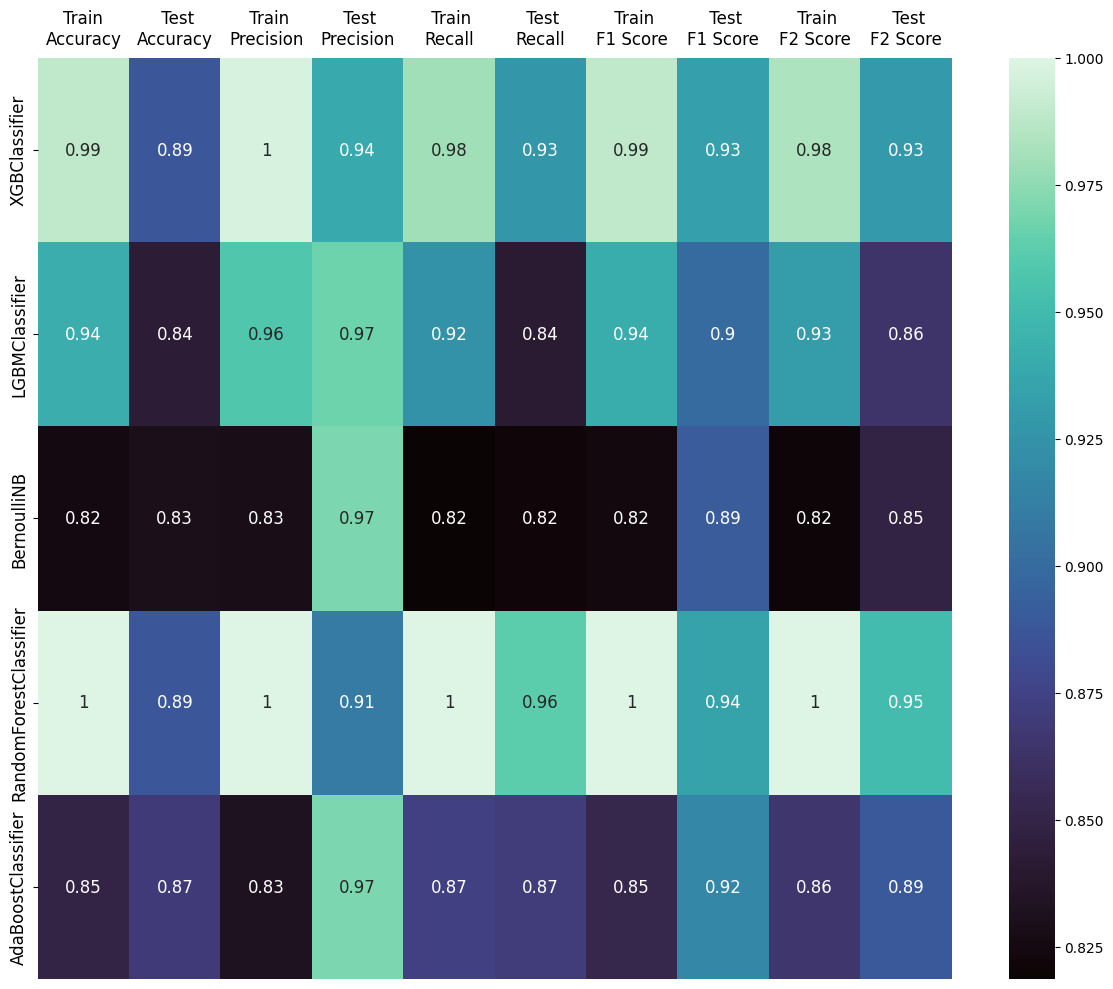

In [ ]:
# Define Classification Algorithm
models = [XGBClassifier(random_state = 400),
          LGBMClassifier(random_state = 400),
          BernoulliNB(),
          RandomForestClassifier(random_state = 400),
          AdaBoostClassifier(random_state = 400)]

# Create model
create_model(X_train, X_test, y_train, y_test, models)

Berdasarkan eksperimen yang telah dilakukan, kami memiliki berbagai skor metrik yang berbeda-beda. Kami memutuskan untuk melakukan _Hyperparameter Tuning_ terhadap dua Algoritma dengan nilai Recall dan F1-Score tertinggi, yaitu `RandomForestClassifier` dan `XGBClassifier`.

Namun, skor yang tinggi juga mengindikasikan adanya kecenderungan _overfit_, sehingga perlu dilakukan validasi lebih lanjut dengan _cross-validation_.

## Hyperparameter Tuning for Machine Learning Models

# 1. Random Forest Classifier

## Fit Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 400)
rf.fit(X_train, y_train)
model_evaluation(rf)

Accuracy (Train): 1.00
Accuracy (Test): 0.89
Precision (Train): 1.00
Precision (Test): 0.71
Recall (Train): 1.00
Recall (Test): 0.50
F1-Score (Train): 1.00
F1-Score (Test): 0.59
F2-Score (Train): 1.00
F2-Score (Test): 0.53
ROC-AUC Score (Train-Probability): 1.00
ROC-AUC Score (Test-Probability): 0.90


## Hyperparameter Tuning

Link: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV

# Dict
parameters = {'n_estimators': [int(x) for x in np.linspace(1, 200, num = 40)],     # number of trees in the forest
              'criterion': ['gini', 'entropy'],                                    # function to measure the quality of a split
              'max_depth': [int(x) for x in np.linspace(2, 100, num = 40)],        # max depth of the tree
              'min_samples_split': [int(x) for x in np.linspace(2, 20, num = 10)], # min number of samples required to split an internal node
              'min_samples_leaf': [int(x) for x in np.linspace(2, 20, num = 10)],  # min number of samples required to be at a leaf node
              'max_features' : ['sqrt', 'log2', None]                              # number of features to consider when looking for the best split
              }

# Init
rf = RandomForestClassifier(random_state=400)
rf_rs = RandomizedSearchCV(rf, parameters, scoring='recall', random_state=4, cv=5)
rf_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=400),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 4, 7, 9, 12, 14, 17,
                                                      19, 22, 24, 27, 29, 32,
                                                      34, 37, 39, 42, 44, 47,
                                                      49, 52, 54, 57, 59, 62,
                                                      64, 67, 69, 72, 74, ...],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [2, 4, 6, 8, 10, 12,
                                                             14, 16, 18, 20],
                                        'min_samples_split': [2, 4, 6, 8, 10,
                                                              12, 14, 16, 18,
                                                              20],
                                        'n_estimators': [1, 6, 11, 16, 21, 26,
                                                         31, 36, 41, 46, 52, 57,
                                                         62, 67, 72, 77, 82, 87,
                                                         92, 97, 103, 108, 113,
                                                         118, 123, 128, 133,
                                                         138, 143, 148, ...]},
                   random_state=4, scoring='recall')

In [ ]:
# Predict & Evaluation
model_evaluation(rf_rs)

Accuracy (Train): 0.96
Accuracy (Test): 0.86
Precision (Train): 0.94
Precision (Test): 0.53
Recall (Train): 0.99
Recall (Test): 0.81
F1-Score (Train): 0.96
F1-Score (Test): 0.64
F2-Score (Train): 0.98
F2-Score (Test): 0.73
ROC-AUC Score (Train-Probability): 1.00
ROC-AUC Score (Test-Probability): 0.92


In [ ]:
# Best parameter
show_best_parameter(rf_rs)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 27, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 16, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 128, 'n_jobs': None, 'oob_score': False, 'random_state': 400, 'verbose': 0, 'warm_start': False}


In [ ]:
# Prediction on training set
y_pred_train = rf_rs.predict(X_train)
# Prediction on testing set
y_pred = rf_rs.predict(X_test)

# Evaluate model
train_test_result(y_train, y_pred_train, y_test, y_pred)

TRAINING RESULTS:
-------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      8350
           1       0.94      0.99      0.96      8350

    accuracy                           0.96     16700
   macro avg       0.96      0.96      0.96     16700
weighted avg       0.96      0.96      0.96     16700

-------------------------------------------------------
Confusion Matrix:
[[7846  504]
 [ 119 8231]]
-------------------------------------------------------

TESTING RESULTS:
-------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      2072
           1       0.53      0.81      0.64       394

    accuracy                           0.86      2466
   macro avg       0.75      0.84      0.78      2466
weighted avg       0.89      0.86      0.87      2

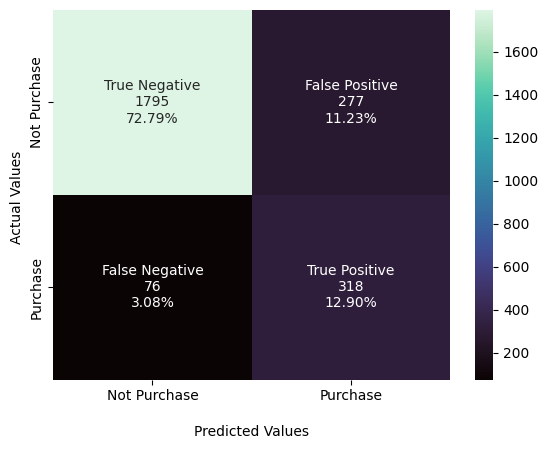

In [ ]:
y_pred = rf_rs.predict(X_test)
c_matrix_plot(y_test, y_pred)

## Learning Curve

parameter value: 2; train: 0.8959285883323175; test: 0.9115368314289634
parameter value: 4; train: 0.9188776004876476; test: 0.9170539511592811
parameter value: 6; train: 0.9383826168023235; test: 0.9186494326088234
parameter value: 8; train: 0.9608712395568145; test: 0.9157910403151519
parameter value: 10; train: 0.9797029509842591; test: 0.9062144768045783
parameter value: 12; train: 0.9933986446269136; test: 0.9133405522999433
parameter value: 14; train: 0.9990870809279644; test: 0.8977360700076435
parameter value: 16; train: 0.9999776542722938; test: 0.8994466956078631
parameter value: 18; train: 0.999998737853634; test: 0.9014470189914352
parameter value: 20; train: 0.9999998135465596; test: 0.9047812996099798
parameter value: 22; train: 0.9999997848614148; test: 0.8999783186014152
parameter value: 24; train: 0.9999997848614149; test: 0.9055064627716911
parameter value: 26; train: 0.9999997561762701; test: 0.9021954559708366
parameter value: 28; train: 0.9999998135465596; test: 0.

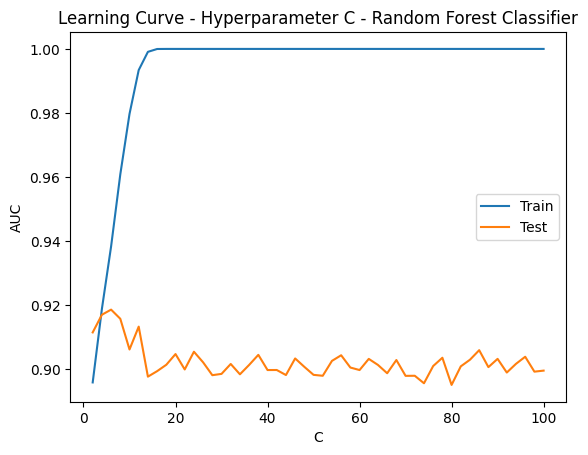

In [ ]:
# Learning Curve
# param_values = [int(x) for x in np.linspace(1, 200, 50)] # n_estimators
param_values = [int(x) for x in np.linspace(2, 100, 50)] # max_depth
# param_values = [int(x) for x in np.linspace(2, 20, 15)]  # min_samples_split
# param_values = [int(x) for x in np.linspace(2, 20, 15)]  # min_samples_leaf

train_scores = []
test_scores = []

for c in param_values:
    model = RandomForestClassifier(n_estimators=128, max_depth=c)
    model.fit(X_train, y_train)

    # Evaluation on training set
    y_pred_train_proba = model.predict_proba(X_train)
    train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
    train_scores.append(train_auc)

    # Evaluation on testing set
    y_pred_proba = model.predict_proba(X_test)
    test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
    test_scores.append(test_auc)

    print('parameter value: ' + str(c) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

plt.plot(param_values, train_scores, label='Train')
plt.plot(param_values, test_scores, label='Test')
plt.xlabel('C')
plt.ylabel('AUC')
plt.title('Learning Curve - Hyperparameter C - Random Forest Classifier')
plt.legend()
plt.show()

## Feature Importance

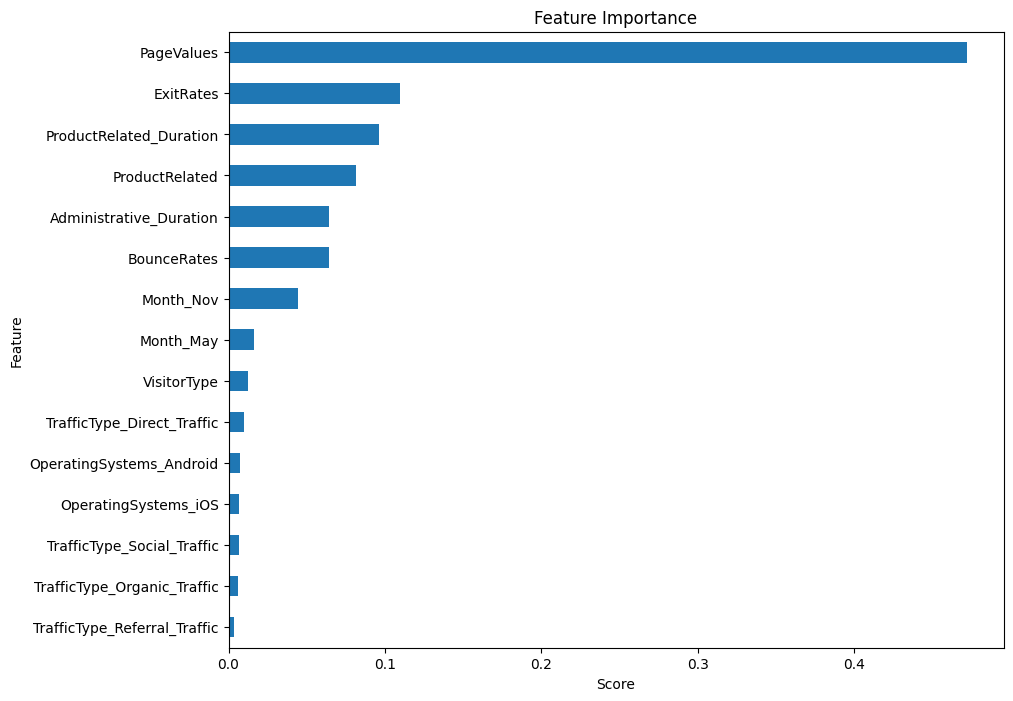

In [ ]:
show_feature_importance(rf_rs.best_estimator_)

# 2. XGBoost Classifier

## Fit Model

Gunakan `scale_pos_weight`

In [ ]:
from xgboost import XGBClassifier

xg = XGBClassifier()
xg.fit(X_train, y_train)
model_evaluation(xg)

Accuracy (Train): 0.99
Accuracy (Test): 0.89
Precision (Train): 0.98
Precision (Test): 0.64
Recall (Train): 1.00
Recall (Test): 0.68
F1-Score (Train): 0.99
F1-Score (Test): 0.66
F2-Score (Train): 0.99
F2-Score (Test): 0.67
ROC-AUC Score (Train-Probability): 1.00
ROC-AUC Score (Test-Probability): 0.91


## Hyperparameter Tuning

Link: https://xgboost.readthedocs.io/en/stable/parameter.html#parameters-for-tree-booster

In [ ]:
# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV

# Dict
parameters = {'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],             # learning_rate, step size shrinkage used in update to prevents overfitting
              'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],            # min_split_loss, min loss reduction required to make a further partition on a leaf node of the tree
              'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],       # max depth of a tree
              'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],  # min sum of instance weight (hessian) needed in a child
              'subsample' : [float(x) for x in np.linspace(0, 1, num = 11)],        # subsample ratio of the training instances
              'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)], # subsample ratio of columns when constructing each tree
              'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],           # reg_lambda, L2 regularization term on weights
              'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)],            # reg_alpha, L1 regularization term on weights
              'tree_method' : ['auto', 'exact', 'approx', 'hist']                   # tree construction algorithm used in XGBoost
              }

# Init
xg = XGBClassifier(random_state = 400)
xg_rs = RandomizedSearchCV(xg, parameters, scoring='recall', random_state=4, cv=5)
xg_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                                   0.30000000000000004, 0.4,
                                                   0.5, 0.6000000000000001,
                                                   0.7000000000000001, 0.8, 0.9,
                                                   1.0],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'min_child_weight': [1, 2, 4, 6, 8, 10,
                                                             12, 14, 16, 18,
                                                             20],
                                        'subsample': [0.0, 0.1, 0.2,
                                                      0.30000000000000004, 0.4,
                                                      0.5, 0.6000000000000001,
                                                      0.7000000000000001, 0.8,
                                                      0.9, 1.0],
                                        'tree_method': ['auto', 'exact',
                                                        'approx', 'hist']},
                   random_state=4, scoring='recall')

In [ ]:
# Predict & Evaluation
model_evaluation(xg_rs)

Accuracy (Train): 0.98
Accuracy (Test): 0.86
Precision (Train): 0.97
Precision (Test): 0.55
Recall (Train): 0.99
Recall (Test): 0.80
F1-Score (Train): 0.98
F1-Score (Test): 0.65
F2-Score (Train): 0.99
F2-Score (Test): 0.73
ROC-AUC Score (Train-Probability): 1.00
ROC-AUC Score (Test-Probability): 0.92


In [ ]:
# Best parameter
show_best_parameter(xg_rs)

{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.5, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 80, 'max_leaves': None, 'min_child_weight': 2, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 400, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': 'approx', 'validate_parameters': None, 'verbosity': None, 'lambda': 0.8, 'eta': 0.04040404040404041, 'alpha': 0.5}


In [ ]:
# Prediction on training set
y_pred_train = xg_rs.predict(X_train)
# Prediction on testing set
y_pred = xg_rs.predict(X_test)

# Evaluate model
train_test_result(y_train, y_pred_train, y_test, y_pred)

TRAINING RESULTS:
-------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      8350
           1       0.97      0.99      0.98      8350

    accuracy                           0.98     16700
   macro avg       0.98      0.98      0.98     16700
weighted avg       0.98      0.98      0.98     16700

-------------------------------------------------------
Confusion Matrix:
[[8073  277]
 [  72 8278]]
-------------------------------------------------------

TESTING RESULTS:
-------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.91      2072
           1       0.55      0.80      0.65       394

    accuracy                           0.86      2466
   macro avg       0.75      0.84      0.78      2466
weighted avg       0.89      0.86      0.87      2

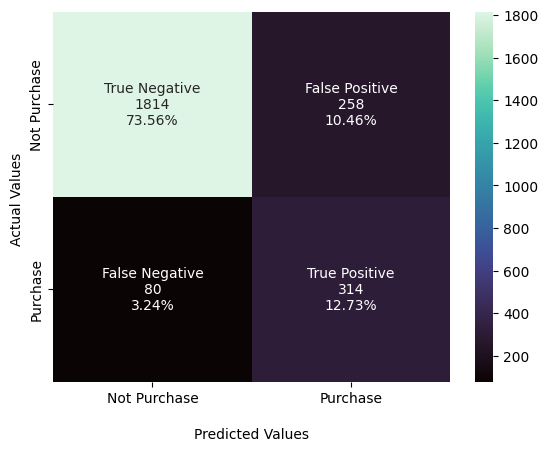

In [ ]:
y_pred = xg_rs.predict(X_test)
c_matrix_plot(y_test, y_pred)

## Learning Curve

parameter value: 2; train: 0.9476936211409516; test: 0.9223003596417301
parameter value: 4; train: 0.9841198680483346; test: 0.9151050751621819
parameter value: 6; train: 0.9992343791458999; test: 0.9096381778805638
parameter value: 8; train: 0.9999981211230234; test: 0.8984012112184702
parameter value: 10; train: 0.9999998996019936; test: 0.9133356525488504
parameter value: 12; train: 0.9999998996019936; test: 0.9087831713148972
parameter value: 14; train: 0.9999998996019936; test: 0.906501112243498
parameter value: 16; train: 0.9999998996019936; test: 0.9094299384591263
parameter value: 18; train: 0.9999998996019936; test: 0.9158014522862238
parameter value: 20; train: 0.9999998996019935; test: 0.9177619651921683
parameter value: 22; train: 0.9999998996019936; test: 0.9106946867099152
parameter value: 24; train: 0.9999998996019936; test: 0.9173436489426336
parameter value: 26; train: 0.9999998996019936; test: 0.9109047635380122
parameter value: 28; train: 0.9999998996019935; test: 0.

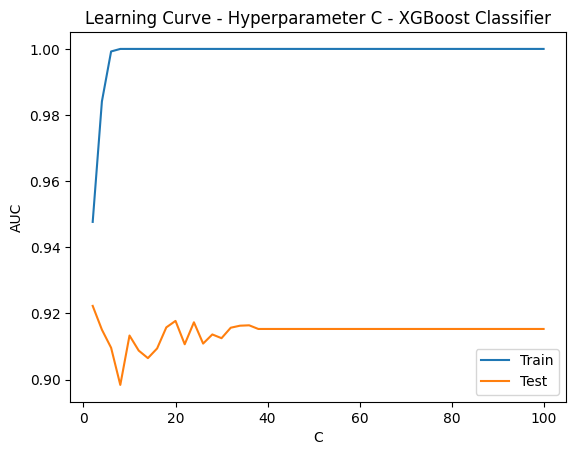

In [ ]:
# Learning Curve
param_values = [int(x) for x in np.linspace(2, 100, 50)] # max_depth

train_scores = []
test_scores = []

for c in param_values:
    model = XGBClassifier(n_estimators=100, max_depth=c)
    model.fit(X_train, y_train)

    # Evaluation on training set
    y_pred_train_proba = model.predict_proba(X_train)
    train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
    train_scores.append(train_auc)

    # Evaluation on testing set
    y_pred_proba = model.predict_proba(X_test)
    test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
    test_scores.append(test_auc)

    print('parameter value: ' + str(c) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

plt.plot(param_values, train_scores, label='Train')
plt.plot(param_values, test_scores, label='Test')
plt.xlabel('C')
plt.ylabel('AUC')
plt.title('Learning Curve - Hyperparameter C - XGBoost Classifier')
plt.legend()
plt.show()

## Feature Importance

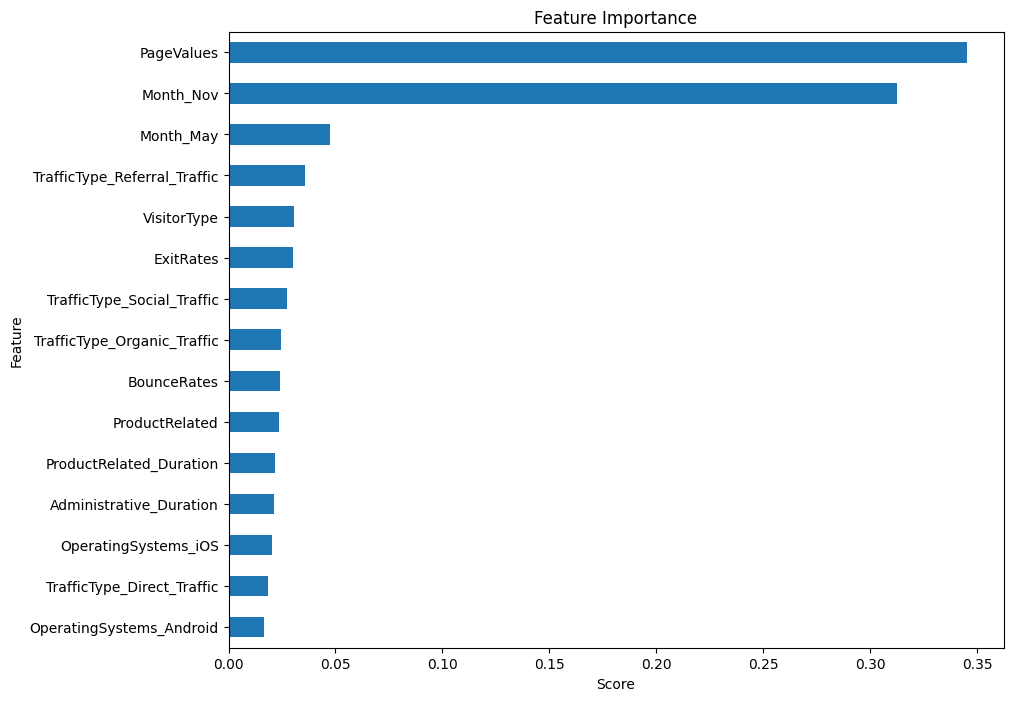

In [ ]:
show_feature_importance(xg_rs.best_estimator_)

# 3. `RandomForestClassifier` vs. `XGBClassifier`

Berdasarkan _hyperparameter tuning_ di atas, dari kedua model, untuk evaluasi klasifikasi,
- Model `RandomForestClassifier` memiliki performa yang lebih baik, karena memiliki nilai _**recall**_ untuk label 1 (kondisi positif) pada data test yang lebih tinggi dibandingkan model `XGBClassifier`. Nilai recall yang tinggi menunjukkan kemampuan model dalam menemukan semua sampel positif.
- Model `RandomForestClassifier` memiliki hasil confusion matrix yang lebih baik, karena jumlah False Negative, FN = 76, yang lebih rendah dibandingkan dengan `XGBClassifier` (FN = 80).

Oleh karena itu, kami memutuskan untuk menginterpretasi model `RandomForestClassifier` dan melakukan ekstraksi terhadap _feature importance_ dengan menggunakan metode SHAP.

# Feature Importance

## Model Interpretation with SHAP Value

Link: https://shap.readthedocs.io/en/latest/index.html

In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 15.5 MB/s eta 0:00:00


Train the model

In [ ]:
rf_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=400),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 4, 7, 9, 12, 14, 17,
                                                      19, 22, 24, 27, 29, 32,
                                                      34, 37, 39, 42, 44, 47,
                                                      49, 52, 54, 57, 59, 62,
                                                      64, 67, 69, 72, 74, ...],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [2, 4, 6, 8, 10, 12,
                                                             14, 16, 18, 20],
                                        'min_samples_split': [2, 4, 6, 8, 10,
                                                              12, 14, 16, 18,
                                                              20],
                                        'n_estimators': [1, 6, 11, 16, 21, 26,
                                                         31, 36, 41, 46, 52, 57,
                                                         62, 67, 72, 77, 82, 87,
                                                         92, 97, 103, 108, 113,
                                                         118, 123, 128, 133,
                                                         138, 143, 148, ...]},
                   random_state=4, scoring='recall')

Draw the plots

In [ ]:
from sklearn.model_selection import train_test_split

X_test1, X_test2, y_test1, y_test2 = train_test_split(X_test, y_test, test_size=0.5, random_state=400)

# Mengambil sampel 50% dari X_test
X_test_sample = X_test1

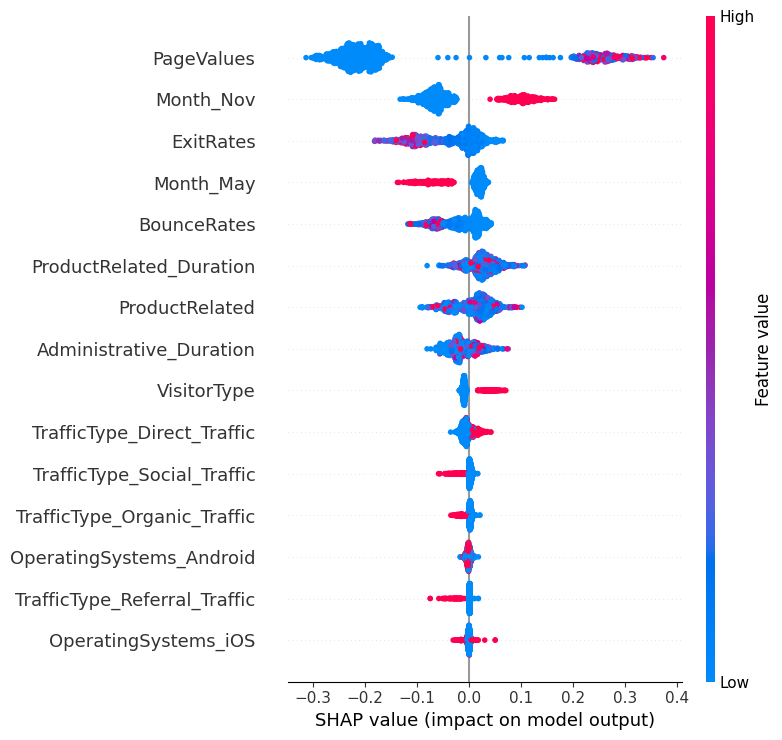

In [ ]:
import shap
explainer = shap.TreeExplainer(rf_rs.best_estimator_)
shap_values = explainer.shap_values(X_test_sample)
shap.summary_plot(shap_values[1], X_test_sample) # Summary shap value terhadap label positive

Force Plot

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test.iloc[0,:])

In [ ]:
# Plot the SHAP values
# shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:])

Berdasarkan hasil SHAP (SHapley Additive exPlanations), kami mencoba memodelkan `RandomForestClassifier` hanya dengan 3 fitur dengan _SHAP value_ tertinggi.

## Feature Importance Evaluation

### Modeling After SHAP

In [ ]:
feature_importance = ['PageValues', 'Month_Nov', 'ExitRates']

In [ ]:
rf = RandomForestClassifier(random_state = 400)
rf.fit(X_train[feature_importance], y_train)

RandomForestClassifier(random_state=400)

In [ ]:
# Prediction on training set
y_pred_train = rf.predict(X_train[feature_importance])
# Prediction on testing set
y_pred = rf.predict(X_test[feature_importance])

# Evaluate model
train_test_result(y_train, y_pred_train, y_test, y_pred)

TRAINING RESULTS:
-------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      8350
           1       0.98      0.95      0.96      8350

    accuracy                           0.96     16700
   macro avg       0.96      0.96      0.96     16700
weighted avg       0.96      0.96      0.96     16700

-------------------------------------------------------
Confusion Matrix:
[[8160  190]
 [ 440 7910]]
-------------------------------------------------------

TESTING RESULTS:
-------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      2072
           1       0.53      0.68      0.59       394

    accuracy                           0.85      2466
   macro avg       0.73      0.78      0.75      2466
weighted avg       0.87      0.85      0.86      2

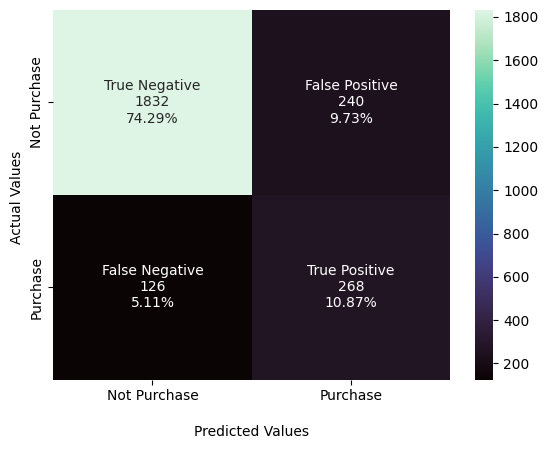

In [ ]:
y_pred = rf.predict(X_test[feature_importance])
c_matrix_plot(y_test, y_pred)

### Hyperparameter Tuning

In [ ]:
# Dict
parameters = {'n_estimators': [int(x) for x in np.linspace(1, 200, num = 40)],     # number of trees in the forest
              'criterion': ['gini', 'entropy'],                                    # function to measure the quality of a split
              'max_depth': [int(x) for x in np.linspace(2, 100, num = 40)],        # max depth of the tree
              'min_samples_split': [int(x) for x in np.linspace(2, 20, num = 10)], # min number of samples required to split an internal node
              'min_samples_leaf': [int(x) for x in np.linspace(2, 20, num = 10)],  # min number of samples required to be at a leaf node
              'max_features' : ['sqrt', 'log2', None]                              # number of features to consider when looking for the best split
              }

# Init
rs = RandomizedSearchCV(rf, parameters, scoring='recall', random_state=4, cv=5)
rs.fit(X_train[feature_importance], y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=400),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 4, 7, 9, 12, 14, 17,
                                                      19, 22, 24, 27, 29, 32,
                                                      34, 37, 39, 42, 44, 47,
                                                      49, 52, 54, 57, 59, 62,
                                                      64, 67, 69, 72, 74, ...],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [2, 4, 6, 8, 10, 12,
                                                             14, 16, 18, 20],
                                        'min_samples_split': [2, 4, 6, 8, 10,
                                                              12, 14, 16, 18,
                                                              20],
                                        'n_estimators': [1, 6, 11, 16, 21, 26,
                                                         31, 36, 41, 46, 52, 57,
                                                         62, 67, 72, 77, 82, 87,
                                                         92, 97, 103, 108, 113,
                                                         118, 123, 128, 133,
                                                         138, 143, 148, ...]},
                   random_state=4, scoring='recall')

In [ ]:
print(show_best_parameter(rs))

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 27, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 16, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 128, 'n_jobs': None, 'oob_score': False, 'random_state': 400, 'verbose': 0, 'warm_start': False}
None


In [ ]:
print(rs.best_params_)

{'n_estimators': 128, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 27, 'criterion': 'gini'}


In [ ]:
best_params = rs.best_params_
rf = RandomForestClassifier(**best_params, random_state = 400)
rf.fit(X_train[feature_importance], y_train)

RandomForestClassifier(max_depth=27, min_samples_leaf=4, min_samples_split=16,
                       n_estimators=128, random_state=400)

In [ ]:
y_pred_train = rf.predict(X_train[feature_importance])
y_pred = rf.predict(X_test[feature_importance])

# Evaluate model
train_test_result(y_train, y_pred_train, y_test, y_pred)

TRAINING RESULTS:
-------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      8350
           1       0.91      0.92      0.91      8350

    accuracy                           0.91     16700
   macro avg       0.91      0.91      0.91     16700
weighted avg       0.91      0.91      0.91     16700

-------------------------------------------------------
Confusion Matrix:
[[7561  789]
 [ 643 7707]]
-------------------------------------------------------

TESTING RESULTS:
-------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.90      2072
           1       0.51      0.85      0.64       394

    accuracy                           0.85      2466
   macro avg       0.74      0.85      0.77      2466
weighted avg       0.89      0.85      0.86      2

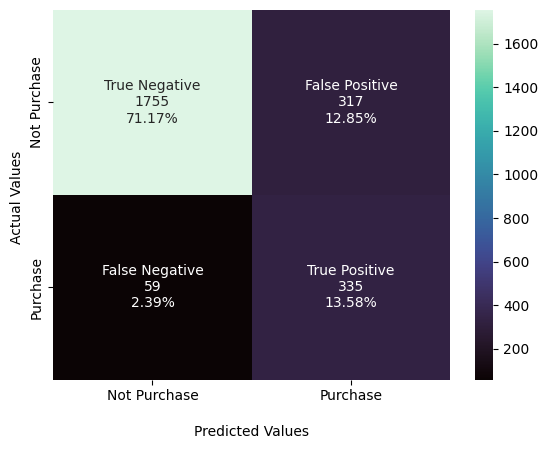

In [ ]:
y_pred = rf.predict(X_test[feature_importance])
c_matrix_plot(y_test, y_pred)

## Business Insights

* Pada fitur `PageValues`, bagi pelanggan yang sering berkunjung ke situs web dan melakukan transaksi akan mendapatkan kupon gratis belanja sebesar Rp50.000 yang dapat digunakan pada transaksi berikutnya.
* Pada fitur `Month`, diketahui bahwa bulan 
November merupakan bulan yang sering
dikunjungi pengunjung. Solusi kita, coba untuk mengadakan
suatu event di bulan tersebut seperti event (yang dilakukan
kompetitor) 1.1 hingga 12.12. serta mengadakan campaign atau challenge untuk meningkatkan engagement.
* Pada fitur `ExitRates`, kami akan meningkatkan user experience, menyederhanakan proses pembelian, serta menampilkan floating review terbaik pada halaman-halaman dengan ExitRates tinggi.


## Business Simulation

In [ ]:
# Asumsi jumlah pengunjung berdasarkan Confusion Matrix
c_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = c_matrix.flatten() / np.sum(c_matrix)

print(f'Confusion Matrix :\n{c_matrix}\n'
      f'\nJumlah Pengunjung:\n'
      f'TN: {c_matrix[0][0]} orang atau {round(tn * 100, 2)}%\n'
      f'FP: {c_matrix[0][1]} orang atau {round(fp * 100, 2)}%\n'
      f'FN: {c_matrix[1][0]} orang atau {round(fn * 100, 2)}%\n'
      f'TP: {c_matrix[1][1]} orang atau {round(tp * 100, 2)}%')

Confusion Matrix :
[[1755  317]
 [  59  335]]

Jumlah Pengunjung:
TN: 1755 orang atau 71.17%
FP: 317 orang atau 12.85%
FN: 59 orang atau 2.39%
TP: 335 orang atau 13.58%


#### Penawaran diskon untuk pengunjung yang diprediksi tidak melakukan transaksi pembelian

Kami menggunakan data _gross profit margin_ (GPM) dari emiten GOTO (Gojek Tokopedia) tahun 2022, yang diakses melalui [TradingView](https://www.tradingview.com/symbols/IDX-GOTO/financials-statistics-and-ratios/), yaitu sebesar 26,05% atau dibulatkan menjadi 26%.

In [ ]:
import math

df = df_test
visitor = df['Purchase'].shape[0]
purchaser = df['Purchase'].value_counts()[1]
# purchaser = int((tp + fn) * visitor)

# Discount Offering to Purchase Predicted Visitors
# Assumption
cogs = 100000
gpm = 0.26                               # Gross Profit Margin 26%
purchase_revenue = cogs / (1 - gpm)
intention_rate = 0.15                    # Shifting visitors intention from Not Purchase to Purchase effectivity
treatment_cost = 0.10 * purchase_revenue # Diskon 10%
new_visitor = 50 * visitor               # Visitor growth forecast 2024

# Initial Condition
conversion_rate = purchaser / visitor
revenue = conversion_rate * (purchase_revenue - cogs) * new_visitor
cost = fn * new_visitor * treatment_cost # Diskon diberikan kepada FN
profit = revenue - cost

print(f'         Before:\nConversion Rate: {conversion_rate * 100:.2f}%')
print(f'   Gross Profit: Rp{profit:,.0f}\n')

# Simulation or Final Condition
new_purchaser = math.ceil(intention_rate * tn * visitor)                    
new_conversion_rate = (purchaser + new_purchaser) / visitor
new_revenue = new_conversion_rate * (purchase_revenue - cogs) * new_visitor
new_cost = ((intention_rate * tn) + fn) * new_visitor * treatment_cost      # Pengunjung yang diprediksi tidak melakukan transaksi pembelian
new_profit = new_revenue - new_cost

print(f'          After:\nConversion Rate: {new_conversion_rate * 100:.2f}%')
print(f'   Gross Profit: Rp{new_profit:,.0f}')

         Before:
Conversion Rate: 15.98%
   Gross Profit: Rp652,297,297

          After:
Conversion Rate: 26.68%
   Gross Profit: Rp938,209,459


Dengan memberikan diskon sebesar 10%,
- _Conversion rate_ meningkat dari 15,98% menjadi 26,68% serta
- _Gross profit_ meningkat dari Rp652.297.297 menjadi Rp938.209.459.

Untuk meningkatkan profit, ada beberapa faktor yang dapat memengaruhi profit, seperti:
- _treatment cost_ atau diskon,
- _visitor_,
- _conversion rate_, dan
- _intention_rate_.


#### Penawaran diskon untuk menurunkan _false negative_ (FN) dan _false negative_ (FP)

In [ ]:
df = df_test
visitor = df['Purchase'].shape[0] # Visitor pada tahun 2022
new_visitor = 50 * visitor        # Visitor growth forecast 2024

# Asumsi untuk cost dan revenue
cost_fn = 20000     # Diskon 20K
cost_fp = 10000     # Diskon 10K
revenue_tp = 100000 # Pendapatan 100K

# Total cost dan revenue
total_cost_fn = fn * new_visitor * cost_fn
total_cost_fp = fp * new_visitor * cost_fp
total_revenue_tp = tp * new_visitor * revenue_tp
print(f'Pengeluaran dari FN: Rp{total_cost_fn:,.0f}')
print(f'Pengeluaran dari FP: Rp{total_cost_fp:,.0f}')
print(f' Pendapatan dari TP: Rp{total_revenue_tp:,.0f}')

# Recall
recall = tp / (tp + fn)

# Potential Profit
potential_profit = total_revenue_tp - (total_cost_fn + total_cost_fp)

print(f'             Recall: {recall * 100:.0f}%')
print(f'   Potensial Profit: Rp{potential_profit:,.0f}')

Pengeluaran dari FN: Rp59,000,000
Pengeluaran dari FP: Rp158,500,000
 Pendapatan dari TP: Rp1,675,000,000
             Recall: 85%
   Potensial Profit: Rp1,457,500,000


In [ ]:
# Asumsi lain
revenue = total_revenue_tp          # the total amount of sales generated in a period
cost_of_goods_sold = 0.48 * revenue # the direct costs of producing the goods sold by a company
operating_expenses = 0.20 * revenue # an expense that a business incurs through its normal business operations
interest_expenses = 0.05 * revenue  # the cost incurred by an entity for borrowed funds
tax_rate = 0.10                     # a percentage at which a company is taxed

# Net Profit Calculation
gross_profit = revenue - cost_of_goods_sold                    # calculated by subtracting the cost of goods sold from revenue
gross_profit_margin = gross_profit / revenue
operating_income = gross_profit - operating_expenses           # the amount of profit realized from a business's ongoing operations
net_income_before_taxes = operating_income - interest_expenses # calculated as revenues minus expenses, interest, and taxes
taxes = net_income_before_taxes * tax_rate
net_profit = net_income_before_taxes - taxes                   # a company's profit after all taxes have been paid

# Print
print(f'Gross Profit Margin: {gross_profit_margin * 100:.0f}%')
print(f'       Gross Profit: Rp{int(gross_profit):,.0f}')
print(f'         Net Profit: Rp{int(net_profit):,.0f}')

Gross Profit Margin: 52%
       Gross Profit: Rp871,000,000
         Net Profit: Rp407,025,000


Kami asumsikan, gross profit margin (GPM) naik menjadi 2x lipat menjadi 52%, dengan menekan _direct and indirect costs_, akan memberikan dampak terhadap kenaikan profit perusahaan, yaitu dari Rp435.500.000 menjadi Rp871.000.000.

Referensi dan Formula:
- [Revenue](https://www.investopedia.com/terms/r/revenue.asp) atau Sales
- [Cost of Goods Sold (COGS)](https://www.investopedia.com/terms/c/cogs.asp) atau Cost of Sales
- [Operating Expenses](https://www.investopedia.com/terms/o/operating_expense.asp)
- [Interest Expenses](https://www.investopedia.com/terms/i/interestexpense.asp)
- [Tax Rate](https://www.investopedia.com/terms/t/taxrate.asp)
- [Gross Profit](https://www.investopedia.com/terms/g/grossprofit.asp) = Revenue - Cost of Goods Sold
- [Gross Profit Margin](https://www.investopedia.com/terms/g/gross_profit_margin.asp) = Gross Profit / Revenue
- [Operating Income](https://www.investopedia.com/terms/o/operatingincome.asp) = Gross Profit - Operating Expenses
- [Net Income](https://www.investopedia.com/terms/n/netincome.asp) Before Taxes = Operating Income - Interest Expenses
- [Net Profit](https://www.investopedia.com/terms/n/net-income-after-taxes-niat.asp) atau Net Income After Taxes = Net Income - Taxes
- [Operating Income vs. Gross Profit](https://www.investopedia.com/ask/answers/122414/what-difference-between-operating-income-and-gross-profit.asp)

## Business Recommendation

* Menawarkan Discount kepada pengunjung yang diprediksi tidak melakukan transaksi
*   Pada fitur `ExitRates` perusahaan dapat mengimprove UI/UX design untuk meningkatkan durasi pelanggan dalam mengakses online shopping seperti menambahkan fitur game dan live. Selain itu, dapat menampilkan rekomendasi Produk ke halaman product berdasarkan riwayat history customer sehingga dapat membantu customer menambahkan ke keranjang.
*   Pada fitur `Month_Nov`, bulan November merupakan bulan yang memberikan kontribusi yang besar terhadap revenue perusahaan. Oleh karena itu, untuk meningkatkan revenue pada bulan yang lain, kita dapat memberikan promo seperti event 1.1 hingga 12.12 dan promo di hari-hari spesial (Valentine, Ramadhan, Natal, dan lain-lain).
*   Pada fitur `PagesValue` dapat meningkatkan kualitas konten yang disajikan seperti foto produk yang menarik dan deskripsi produk yang jelas.


